## Perform main sample size and dimensionality scaling experiment

***Note that here we have set runs=1 in the config file to reproduce the figure in the manuscript enable multiple runs***

In [1]:
%load_ext autoreload
%autoreload 2

### Load the configs and set up the plotting 

In [2]:
import datetime
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from torch.distributions import MultivariateNormal

from labproject.data import DATASETS, DISTRIBUTIONS, get_dataset
from labproject.experiments import *
from labproject.plotting import cm2inch, generate_palette
from labproject.utils import get_cfg, get_cfg_from_file, get_log_path, set_seed

# inline plotting
%matplotlib inline



print("Running experiments...")
# load the config file
cfg = get_cfg_from_file("conf_main_scaling_experiment")
cfg.running_user = 'main_scaling_experiment'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# setup colors and labels for plotting

color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleSampleSizeKL':'kl', 'ScaleSampleSizeSW':'wasserstein',
           'ScaleSampleSizeMMD':'mmd', 'ScaleSampleSizeC2ST':'c2st',
           'ScaleSampleSizeFID':'fid', 'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st', 'ScaleGammaMMD':'mmd',
           'ScaleDimFID':'fid',}

mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
           'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
           'ScaleSampleSizeFID':'FD', 'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
           'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
           'ScaleDimFID':'FD', 'ScaleGammaMMD':'MMD'}

# dark and light colors for inter vs. intra comparisons 
col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]
for e, exp_name in enumerate(cfg.experiments_dim):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]
    
color_list = [col_light, col_dark] # make this a list to account for true and shifted

label_true = {}
label_shift = {}
for e, data_name in enumerate(cfg.data):
    label_true[data_name] = "true"
    label_shift[data_name] = "generated"
    
label_list = [label_true, label_shift]
label_list[1]['toy_2d'] = 'approx.'
label_list[1]['random'] = 'shifted'


Running experiments...
Seed: 0
Experiments: ['ScaleSampleSizeSW', 'ScaleSampleSizeC2ST', 'ScaleSampleSizeMMD']
Data: ['toy_2d', 'random', 'random']


## Loop over the three dataset conditions for the sample size experiments and the dimensionality scaling 

toy_2d 10000 2
Experiment ScaleSampleSizeSW finished in 0.024785280227661133
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_SW_toy_2d_ds_0_bw_1_0_.pkl
Experiment ScaleSampleSizeSW finished in 0.024083852767944336
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_SW_toy_2d_ds_0_bw_1_1_.pkl


/tmp/ipykernel_1241909/2600699566.py:28: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  torch.mean(dataset_gt, axis=0).T, torch.cov(dataset_gt.T)


Experiment ScaleSampleSizeC2ST finished in 11.121685981750488
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_C2ST_toy_2d_ds_0_bw_1_0_.pkl
Experiment ScaleSampleSizeC2ST finished in 18.588348388671875
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_C2ST_toy_2d_ds_0_bw_1_1_.pkl
MMD toy_2d 0 1
Experiment ScaleSampleSizeMMD finished in 0.4107973575592041
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_MMD_toy_2d_ds_0_bw_1_0_.pkl
MMD toy_2d 0 1
Experiment ScaleSampleSizeMMD finished in 0.35918641090393066
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_MMD_toy_2d_ds_0_bw_1_1_.pkl
random 10000 10
Experiment ScaleSampleSizeSW finished in 0.024955272674560547
Numerical results saved to results/main_scaling_experiment/main_scaling_experiment_SW_random_ds_1_bw_5_0_.pkl
Experiment ScaleSampleSizeSW finished in 0.023607969284057617
Numerical results saved to 

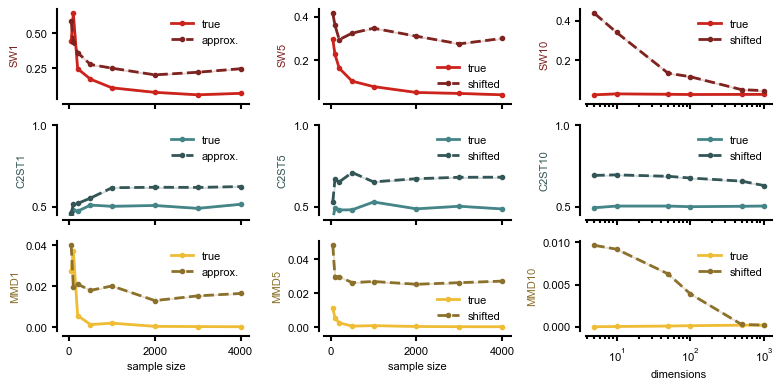

In [3]:
# make comparison plots
fig, axes = plt.subplots(3, 3, figsize=cm2inch((20, 10)), sharex='col')
for ax in axes.flatten():
    # move spines outward
    ax.spines['bottom'].set_position(('outward', 4))
    ax.spines['left'].set_position(('outward', 4))
    ax.locator_params(nbins=3)

# Loop over all three datasets
for dd, ds in enumerate(cfg.data):

    # specify the bandwidth parameters to vary for each dataset
    # custom_values = np.linspace(cfg.val_min[dd], cfg.val_max[dd], cfg.val_step[dd]) # switch for linspacing

    dataset_fn = get_dataset(cfg.data[dd])
    # sample double the number of samples to ensure variability at the highest samples set size
    n_samples = cfg.n[dd] * cfg.runs

    # generate the ground truth and the two approximations inter and intra
    dataset_gt = dataset_fn(n_samples, cfg.d[dd])
    dataset_intra = dataset_fn(n_samples, cfg.d[dd])

    print(cfg.data[dd], n_samples, cfg.d[dd])

    # generate the inter dataset
    if cfg.data[dd] == "toy_2d":
        dataset_inter = MultivariateNormal(
            torch.mean(dataset_gt, axis=0).T, torch.cov(dataset_gt.T)
        ).sample((n_samples,))
    elif cfg.data[dd] == "random" and cfg.augmentation[dd] == "mean_shift":
        # shift the mean by 1 for all dimensions
        dataset_inter = dataset_fn(n_samples, cfg.d[dd]) + 1
    elif cfg.data[dd] == "random" and cfg.augmentation[dd] == "one_dim_shift":
        # just shift the first dimension by 1
        dataset_inter = dataset_fn(n_samples, cfg.d[dd])
        dataset_inter[:, 0] += 1  # just shift the mean of first dim by 1

    if dd < 2:  # for the first two datasets, we compare sample sizes
        for e, exp_name in enumerate(cfg.experiments):
            experiment = globals()[exp_name]()
            ax = axes[e, dd]
            for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
                assert (
                    dataset_gt.shape == data_comp.shape
                ), f"Dataset shapes do not match: {dataset_gt.shape} vs. {data_comp.shape}"
                time_start = time.time()
                if mapping[exp_name] == "MMD":
                    print(f"MMD {cfg.data[dd]} {dd} {cfg.mmd_bandwidth[dd][e]}")
                    output = experiment.run_experiment(
                        dataset1=dataset_gt,
                        dataset2=data_comp,
                        sample_sizes=cfg.sample_size,
                        nb_runs=cfg.runs,
                        bandwidth=cfg.mmd_bandwidth[dd][e],
                    )
                else:
                    output = experiment.run_experiment(
                        dataset1=dataset_gt,
                        dataset2=data_comp,
                        sample_sizes=cfg.sample_size,
                        nb_runs=cfg.runs,
                    )
                time_end = time.time()
                print(f"Experiment {exp_name} finished in {time_end - time_start}")

                log_path = get_log_path(
                    cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_ds_{dd}_bw_{cfg.mmd_bandwidth[dd][e]}_{dc}", timestamp=False
                )
                os.makedirs(os.path.dirname(log_path), exist_ok=True)
                experiment.log_results(output, log_path)
                print(f"Numerical results saved to {log_path}")

                experiment.plot_experiment(
                    *output,
                    cfg.data[dd],
                    ax=ax,
                    color=color_list[dc][exp_name],
                    label=label_list[dc][cfg.data[dd]],
                    linestyle="-" if dc == 0 else "--",
                    lw=2,
                    marker="o",
                )
                ax.set_ylabel(mapping[exp_name] + str(cfg.mmd_bandwidth[dd][e]) if mapping[exp_name]  == 'MMD' else mapping[exp_name])
                ax.set_xlabel("")
                if mapping[exp_name] == "C2ST":
                    ax.set_ylim([0.45, 1])
                    ax.set_yticks([0.5, 1])
            ax.legend()
    else:  # for the last dataset, we compare dimensions
        for e, exp_name in enumerate(cfg.experiments_dim):
            experiment = globals()[exp_name]()
            ax = axes[e, 2]
            ax.set_xscale("log")
            for dc, data_comp in enumerate([dataset_intra, dataset_inter]):
                assert (
                    dataset_gt.shape == data_comp.shape
                ), f"Dataset shapes do not match: {dataset_gt.shape} vs. {data_comp.shape}"
                time_start = time.time()
                if exp_name == "ScaleDimMMD":
                    output = experiment.run_experiment(
                        dataset1=dataset_gt,
                        dataset2=data_comp,
                        dataset_size=cfg.n[dd],
                        dim_sizes=cfg.dim_sizes,
                        nb_runs=cfg.runs_dim,  # deterministic
                        bandwidth=cfg.mmd_bandwidth[dd][e],
                    )
                    print(f"MMD {cfg.data[dd]} {dd} {cfg.mmd_bandwidth[dd][e]}")
                else:
                    output = experiment.run_experiment(
                        dataset1=dataset_gt,
                        dataset2=data_comp,
                        dataset_size=cfg.n[dd],
                        dim_sizes=cfg.dim_sizes,
                        nb_runs=cfg.runs_dim,
                    )
                time_end = time.time()
                print(f"Experiment {exp_name} finished in {time_end - time_start}")

                log_path = get_log_path(
                    cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_ds_{dd}_bw_{cfg.mmd_bandwidth[dd][e]}_{dc}", timestamp=False
                )
                os.makedirs(os.path.dirname(log_path), exist_ok=True)
                experiment.log_results(output, log_path)
                print(f"Numerical results saved to {log_path}")
                experiment.plot_experiment(
                    *output,
                    cfg.data[dd],
                    ax=ax,
                    color=color_list[dc][exp_name],
                    label=label_list[dc][cfg.data[dd]],
                    linestyle="-" if dc == 0 else "--",
                    lw=2,
                    marker="o",
                )
                ax.set_ylabel(mapping[exp_name] + str(cfg.mmd_bandwidth[dd][e]) if mapping[exp_name]  == 'MMD' else mapping[exp_name])
                ax.set_xlabel("")
                if mapping[exp_name] == "C2ST":
                    ax.set_ylim([0.45, 1])
                    ax.set_yticks([0.5, 1])

            ax.legend()

axes[-1, -1].set_xlabel("dimensions")
axes[-1, 0].set_xlabel("sample size")
axes[-1, 1].set_xlabel("sample size")


os.makedirs("./results/plots", exist_ok=True)
fig.tight_layout()
fig.savefig(f"./results/plots/{cfg.exp_log_name}_metric_comparison_sample_size_and_dimensionality.png", dpi=300)
fig.savefig(f"./results/plots/{cfg.exp_log_name}_metric_comparison_sample_size_and_dimensionality.pdf", dpi=300)


print("Finished running experiments.")